In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import os
import random
import math
import numpy as np
from collections import OrderedDict

import torch
from torch import nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision.ops import misc as misc_nn_ops

### Funtion for visualization
def draw_bb(img, boxes, color='g', figsize=(8,8)):
    fig,ax = plt.subplots(1, figsize=figsize)
    for box in boxes:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor=color,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

### Fuction for vislualize boudning with two differnt colors
def draw_bb2(img, boxes1, boxes2, color1='g', color2='r'):
    fig,ax = plt.subplots(1)
    for box in boxes1:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor=color1,facecolor='none')
        ax.add_patch(rect)
    for box in boxes2:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor=color2,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

In [2]:
class PennFudanDataset(data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __len__(self):
        return len(self.imgs)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

# Define Faster RCNN model

In [3]:
class FASTERCNN(nn.Module):

    def __init__(self, backbone, rpn, roi_heads, transform):
        super(FASTERCNN, self).__init__()
        '''
            backbone (nn.Module): Feature extractor (In this tutorial, we will use ResNet50)
            rpn (nn.Module): Region Proposal Network
            roi_heads (nn.Module): Classifier using RoI Align
            transform (torchvision.transforms): Data transformation
        '''
        
        self.transform = transform
        
        self.backbone = backbone
        
        self.rpn = rpn
        
        self.roi_heads = roi_heads

    def forward(self, images, targets=None):
        '''
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image        
        '''
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        original_image_sizes = [img.shape[-2:] for img in images]
        
        images, targets = self.transform(images, targets)
    
        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([(0, features)])

        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        #  During training, it returns a dict[Tensor] which contains the losses.
        if self.training:
            return losses
        # During testing, it returns list[BoxList] contains additional fields like `scores`
        return detections

### Image Transform Hyperparameters

In [4]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform

min_size=800
max_size=1333

image_mean=[0.485, 0.456, 0.406]
image_std=[0.229, 0.224, 0.225]        

transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

### TODO 1 : Define Backbone networks
- Define resnet 50 model pretrained on imagenet (from troch vision)
- Freeze '~ layer 1'
- Freeze BatchNormalization
- Fill the forward function

In [5]:
from torchvision.models import resnet50


### Define MyResnet 50 Networks
class MyResnet50(nn.Module):
    def __init__(self):
        super(MyResnet50, self).__init__()
        # load pretrained resnet 50 model
        self.model = resnet50(pretrained=True)
        #ResNet50 pretrained를 불러오고 새로운 task에 사용할 경우.
        #ResNet50이 기존의 pretrained된 내용이 다 사라진다.
        #따라서 이것을 고정해주어야 한다. 이것을 Freeze라고 한다.
        
        # Freeze  ~ layer 1
        for name, parameter in self.model.named_parameters():
            if 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                parameter.requires_grad_(False)
                # 함수 뒤에 언더바가 붙는 경우 리턴값 없이 자신이 가진 변수를 변경한다는 의미 inplace operator
    
        # Freeze BN
        for name, parameter in self.model.named_parameters():
            if 'bn' not in name:
                parameter.requires_grad_(False)
                
        # 비슷한 데이터셋 & 작은 데이서셋
        # 마지막 부분 + classifier (앞부분고정)
        
        # 다른 데이터셋 & 작은 데이터셋
        # 앞부분 트레이닝 & classfier 트레이닝 (= 뒤 고정)
        
        # 데이터셋의 크기가 크면, 네트워크 전체를 다시 fine-tuning
        
        # RCNN 계열 vs YOLO
                

        # Define out_channels
        self.out_channels = 2048
    
    def forward(self, x):
        ### Forward thorugh predefined layers till layer4
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        
        return x

backbone = MyResnet50()

In [6]:
### Output Channel variable check
print(backbone.out_channels)

2048


In [7]:
### Check number of layers with requiered_grad
nl = []
for name, parameter in backbone.named_parameters():
    if parameter.requires_grad:
        nl.append(name)
        print(name)
print(len(nl))

model.layer2.0.bn1.weight
model.layer2.0.bn1.bias
model.layer2.0.bn2.weight
model.layer2.0.bn2.bias
model.layer2.0.bn3.weight
model.layer2.0.bn3.bias
model.layer2.1.bn1.weight
model.layer2.1.bn1.bias
model.layer2.1.bn2.weight
model.layer2.1.bn2.bias
model.layer2.1.bn3.weight
model.layer2.1.bn3.bias
model.layer2.2.bn1.weight
model.layer2.2.bn1.bias
model.layer2.2.bn2.weight
model.layer2.2.bn2.bias
model.layer2.2.bn3.weight
model.layer2.2.bn3.bias
model.layer2.3.bn1.weight
model.layer2.3.bn1.bias
model.layer2.3.bn2.weight
model.layer2.3.bn2.bias
model.layer2.3.bn3.weight
model.layer2.3.bn3.bias
model.layer3.0.bn1.weight
model.layer3.0.bn1.bias
model.layer3.0.bn2.weight
model.layer3.0.bn2.bias
model.layer3.0.bn3.weight
model.layer3.0.bn3.bias
model.layer3.1.bn1.weight
model.layer3.1.bn1.bias
model.layer3.1.bn2.weight
model.layer3.1.bn2.bias
model.layer3.1.bn3.weight
model.layer3.1.bn3.bias
model.layer3.2.bn1.weight
model.layer3.2.bn1.bias
model.layer3.2.bn2.weight
model.layer3.2.bn2.bias


In [8]:
### Check forward
x = torch.rand(2, 3, 244, 244)
print(backbone(x).shape)

torch.Size([2, 2048, 8, 8])


### Region Proposal Networks

In [9]:
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork

### Define Anchor generator
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))    # 5x1
aspect_ratios = ((1.0, 2.0, 3.0),) * len(anchor_sizes) # 5x3

### Reference - rpn.py
# Define multi scale/aspect ratio anchors for each feature map grids
rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

### Define Region Proposal Head(Classification, Regression)
class RPNHead(nn.Module):
# conv3x3 - relu - conv1x1 - classification
#                           conv1x1 - regression
    def __init__(self, in_channels, num_anchors):
        super(RPNHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.cls_logits = nn.Conv2d(in_channels, num_anchors, kernel_size=1, stride=1)
        self.bbox_pred = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1, stride=1)

        for l in self.children():
            torch.nn.init.normal_(l.weight, std=0.01)
            torch.nn.init.constant_(l.bias, 0)

    def forward(self, x):
        logits = []
        bbox_reg = []
        for feature in x:
            t = F.relu(self.conv(feature))
            logits.append(self.cls_logits(t))
            bbox_reg.append(self.bbox_pred(t))
        return logits, bbox_reg
    
#rpn_head instantiation
out_channels = backbone.out_channels
rpn_head = RPNHead(out_channels, rpn_anchor_generator.num_anchors_per_location()[0])

### RPN Hyperparameters
# NMS param
rpn_pre_nms_top_n_train=10000
rpn_pre_nms_top_n_test=6000
rpn_post_nms_top_n_train=2000
rpn_post_nms_top_n_test=300
rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)
rpn_nms_thresh=0.7
# IOU threshold for anchor
rpn_fg_iou_thresh=0.7
rpn_bg_iou_thresh=0.3
# RPN batch info
rpn_batch_size_per_image=256 # Number of anchor that are sampled during training of the RPN
rpn_positive_fraction=0.5

### Define RPN
rpn = RegionProposalNetwork(
    rpn_anchor_generator, rpn_head,
    rpn_fg_iou_thresh, rpn_bg_iou_thresh,
    rpn_batch_size_per_image, rpn_positive_fraction,
    rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)       

### RCNN Detectors

In [10]:
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign

### ROI pool(ROI align actually)
# 'ops/Spoolers'
box_roi_pool = MultiScaleRoIAlign(
                featmap_names=[0, 1, 2, 3],
                output_size=7,
                sampling_ratio=2) #number of sampling point in interpolation grids

### Detector FC
class RCNNFC(nn.Module):
    def __init__(self, in_channels, representation_size):
        super(RCNNFC, self).__init__()
        self.fc6 = nn.Linear(in_channels, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        return x

resolution = box_roi_pool.output_size[0]
representation_size = 1024
box_head = RCNNFC(
    out_channels * resolution ** 2,
    representation_size)

### Detector Classifier / Regressor
class FastRCNNPredictor(nn.Module):
    ### FC layers for classification and regression
    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)
    def forward(self, x):
        if x.ndimension() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas

num_classes = 2
representation_size = 1024
box_predictor = FastRCNNPredictor(
                representation_size,
                num_classes)

### Detector Hyperparameters
box_score_thresh=0.05
box_nms_thresh=0.5
box_detections_per_img=30
box_fg_iou_thresh=0.5
box_bg_iou_thresh=0.5
# Detector batch info
box_batch_size_per_image=512
box_positive_fraction=0.25
bbox_reg_weights=None        

### Final Detectors
# 1) Select training samples => foreground / background assign
# 2) Roi pool
# 3) forward box head, predictor
# 4) fastrcnn_loss  ||  Post process
roi_heads = RoIHeads(
    # Box
    box_roi_pool, box_head, box_predictor,
    box_fg_iou_thresh, box_bg_iou_thresh,
    box_batch_size_per_image, box_positive_fraction,
    bbox_reg_weights,
    box_score_thresh, box_nms_thresh, box_detections_per_img)

In [11]:
print(roi_heads)

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign()
  (box_head): RCNNFC(
    (fc6): Linear(in_features=100352, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)


### Instantiate Faster RCNN model

In [12]:
model =FASTERCNN(backbone, rpn, roi_heads, transform)
print(model)

FASTERCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): MyResnet50(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64,

### Train generated model

In [13]:
!pip install pycocotools

In [14]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = 'cpu'

# define dataset
import transforms as T
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

dataset = PennFudanDataset('./data/PennFudanPed',  get_transform(train=True))
dataset_test = PennFudanDataset('./data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

### define training and validation data loaders
### collate_fn - documentation
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=lambda batch: tuple(zip(*batch)))
#     collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=lambda batch: tuple(zip(*batch)))

# move model to device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

### TODO.2 : Train network
- Fill the forward path to calculate losses

In [15]:
##### TODO.3 

# let's train it for 10 epochs
num_epochs = 10
# print loss every 10 mini-batches
print_step = 10

##### TODO
# Loop over num_epochs
for epoch in range(num_epochs):
    
    ## enumerate through data_loader
    for batch_idx, (images, targets) in enumerate(data_loader):
        ### Train mode
        #todo
        model.train()
        
        images = list(image.to(device) for image in images)        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        '''
            -------------
            #   TO DO   #
            -------------
            model input : image (tensor list), target (dict list)
            model output : losses (dict - key: (string) each loss name, value: (tensor) each loss value
        '''
        # Fill this blank
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values()) # torch.cuda.Tensor
        loss_value = losses.item() # float
        
        
        ### BackPropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        ### print itermedicate outputs
        if(batch_idx % print_step == 0):
            print('Epoch: [{}]  [{}/{}]   loss: {}  '.format(epoch, batch_idx//print_step, len(dataset)//(2*print_step), loss_value))

print('Training Done!')

/home/piai/anaconda3/lib/python3.8/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [0/6]   loss: 6.073849678039551  
Epoch: [0]  [1/6]   loss: 4.480965614318848  
Epoch: [0]  [2/6]   loss: 2.883491039276123  
Epoch: [0]  [3/6]   loss: 2.559544086456299  
Epoch: [0]  [4/6]   loss: 2.711172580718994  
Epoch: [0]  [5/6]   loss: 2.3566672801971436  
Epoch: [1]  [0/6]   loss: 2.141329288482666  
Epoch: [1]  [1/6]   loss: 2.1620187759399414  
Epoch: [1]  [2/6]   loss: 2.0878775119781494  
Epoch: [1]  [3/6]   loss: 1.8495543003082275  
Epoch: [1]  [4/6]   loss: 2.069837808609009  
Epoch: [1]  [5/6]   loss: 1.825810432434082  
Epoch: [2]  [0/6]   loss: 1.4512298107147217  
Epoch: [2]  [1/6]   loss: 1.658299446105957  
Epoch: [2]  [2/6]   loss: 1.4396002292633057  
Epoch: [2]  [3/6]   loss: 1.5291613340377808  
Epoch: [2]  [4/6]   loss: 1.8736398220062256  
Epoch: [2]  [5/6]   loss: 1.6084027290344238  
Epoch: [3]  [0/6]   loss: 2.2728476524353027  
Epoch: [3]  [1/6]   loss: 1.5387917757034302  
Epoch: [3]  [2/6]   loss: 1.588903546333313  
Epoch: [3]  [3/6]   los

In [16]:
# predefined evaluation function
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:12  model_time: 0.0586 (0.0586)  evaluator_time: 0.0029 (0.0029)  time: 0.2415  data: 0.1786  max mem: 5478
Test:  [49/50]  eta: 0:00:00  model_time: 0.0616 (0.0586)  evaluator_time: 0.0011 (0.0015)  time: 0.0645  data: 0.0027  max mem: 5478
Test: Total time: 0:00:03 (0.0687 s / it)
Averaged stats: model_time: 0.0616 (0.0586)  evaluator_time: 0.0011 (0.0015)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.516
 Average Recall     (AR) @[ IoU

### Visulization - test data

In [17]:
# eval mode
model.eval();

In [18]:
data_it = iter(data_loader_test)

tensor([0.9931, 0.4954, 0.1584], device='cuda:0', grad_fn=<IndexBackward>)


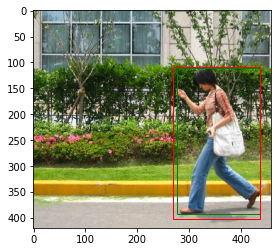

In [19]:
data_test = next(data_it)
img_test = data_test[0][0]
bbox_test = data_test[1][0]['boxes']
prediction = model(list([data_test[0][0].cuda()]))
scores = prediction[0]['scores']
print(scores)
threshold = (scores>0.5).sum().cpu().detach().item()
### transform for visulization
P = torchvision.transforms.ToPILImage()
img_test_PIL = P(img_test)
prediction_bbox_np = prediction[0]['boxes'].cpu().detach().numpy()[:threshold]
draw_bb2(img_test_PIL, bbox_test, prediction_bbox_np)

### Visualization - user input image

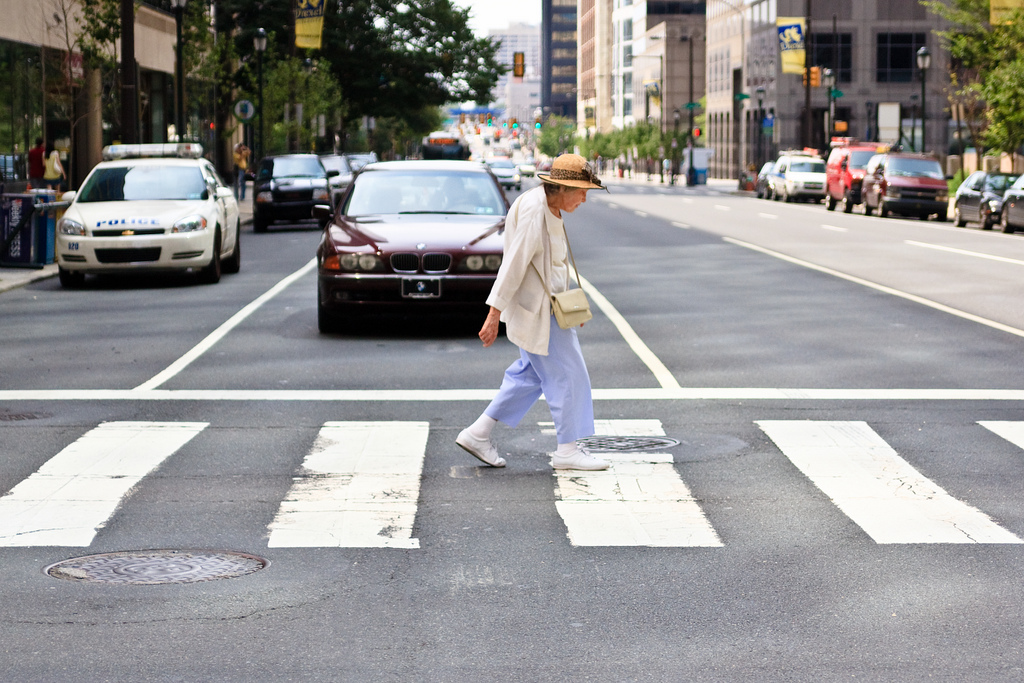

In [20]:
# read image
img_demo = Image.open('./data/PedSample/sample1_easy.jpg').convert("RGB")
img_demo

tensor([0.9819], device='cuda:0', grad_fn=<IndexBackward>)
(1, 4)


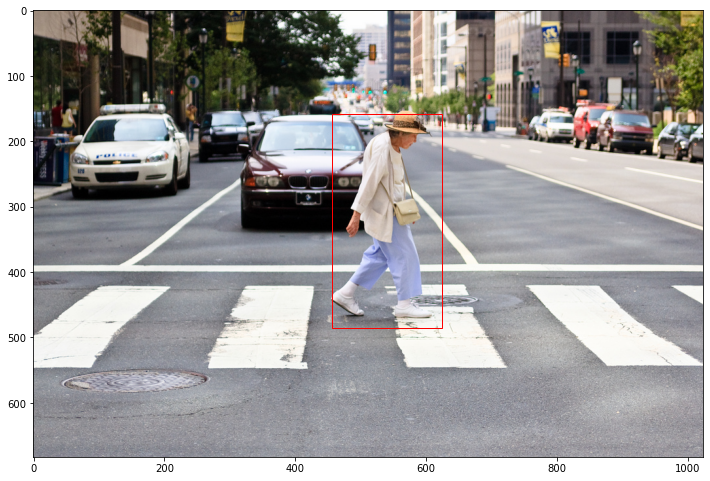

In [21]:
# Forward through trained model
boxes_demo = model([torchvision.transforms.ToTensor()(img_demo).cuda()])[0]['boxes']
scores_demo = model([torchvision.transforms.ToTensor()(img_demo).cuda()])[0]['scores']
boxes_demo_np = boxes_demo.cpu().detach().numpy()
print(scores_demo)
threshold = (scores_demo>0.5).sum().cpu().detach().item()
boxes_demo_np = boxes_demo.cpu().detach().numpy()[:threshold]
print(boxes_demo_np.shape)
# Draw bounding boxes
draw_bb(img_demo, boxes_demo_np, 'r', (12,12))